<h1>Pune Bakery Project

<h2> A] Scraping and cleaning the data from Geospatial Data

<h3>1) Reading Pune data which was extracted into a csv file

In [2]:
import numpy as np # library to handle data in a vectorized manner
import config

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
'''
Another way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. 
Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
'''

"\nAnother way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. \nHere is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/\n"

<h2> B] Dataframe after adding the latitudes and longitudes

<h3>1) Reading the coordinates file

In [2]:
cord_path = '/Users/Rohit/Desktop/Capstone_projs/India_Data/pune_coordinates-2.csv'
df_cord = pd.read_csv(cord_path)
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
0,Adivare,410509,19.159047,73.696210
1,AFMC,411040,18.506342,73.890503
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


In [3]:
df_cord = df_cord.append(pd.DataFrame({"Area Name":['Koregaon Park', 'Kalyani Nagar', 'Boat Club Road', 'Sopan Baug', 'Undri', 'Fatima Nagar'],
              "Postal Code":['411001', '411006', '411001', '411001','411060','411022'],
              "Latitude":[18.536207,18.546328,18.539517,18.5142,18.4567,18.5042 ],
              "Longitude":[73.893974,73.903313,73.878978,73.9040,73.9095,73.9014]}), ignore_index=True)
#df2 = pd.DataFrame({"a":[1, 2, 3], 
#                    "b":[5, 6, 7]}) 
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
0,Adivare,410509,19.159047,73.696210
1,AFMC,411040,18.506342,73.890503
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


In [4]:
df_cord.sort_values(['Area Name'], axis=0, inplace=True)
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
1,AFMC,411040,18.506342,73.890503
0,Adivare,410509,19.159047,73.696210
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


<h3>2) Merging coordinates file with the dataframe

In [5]:
df_cord['Postal Code'] = df_cord['Postal Code'].astype(str)
Pune_filtered = df_cord[df_cord['Postal Code'].str.startswith('411')]
Pune_filtered.rename(columns = {'Area Name':'Neighborhood'}, inplace = True) 
   
#merge Pune_grouped with Pune_data to add latitude/longitude for each neighborhood
#Pune_merged = Pune_merged.join(df.set_index('Postal Code'), on='Postal Code')
#Pune_merged = Pune_merged[['Postal Code','Borough','Neighborhood','Latitude', 'Longitude']]
Pune_filtered.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Neighborhood,Postal Code,Latitude,Longitude
1,AFMC,411040,18.506342,73.890503
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262
16,Ambegaon BK,411046,18.402869,73.853668
24,Ammunition Factory Khadki,411003,18.567988,73.857668


<h2> C] Exploring and Clustering Datasets

<b>Defining credentials for Foursquare

In [4]:
#Rohit
CLIENT_ID = config.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = config.CLIENT_SECRET # your Foursquare Secret
VERSION = config.VERSION # Foursquare API version
LIMIT = config.LIMIT

<h3> 2) Define a function for getting json file and converting it to a dataframe with venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3> 3) Feed in Toronto filtered dataset in the function

In [10]:
Pune_venues = getNearbyVenues(names=Pune_filtered['Neighborhood'],
                                   latitudes=Pune_filtered['Latitude'],
                                   longitudes=Pune_filtered['Longitude'],
                                   radius = 400
                                  )

AFMC          
Airport          
Akurdi          
Ambegaon BK        
Ammunition Factory Khadki      
Anandnagar          
Armament          
Aundh Camp        
Aundh T.S.        
Aundh          
Bajirao Road        
Baner Gaon        
Baner Road        
Bavdhan          
Bhavani Peth        
Bhosari I.E.        
Bhosarigoan          
Bhusari Colony        
Bibvewadi          
Boat Club Road
Botanical Garden        
C D A      
C M E      
Chikhali          
Chikhlee          
Chinchwad East        
Chinchwadgaon          
Congress House Road      
Dapodi Bazar        
Dapodi          
Deccan Gymkhana        
Dhankawadi          
Dhanori          
Dhayari          
Dighi Camp        
Donje          
Dr.B.A. Chowk        
Dukirkline          
East Khadki        
Ex. Serviceman Colony      
Fatima Nagar
Film Institute        
Ganeshkhind          
Ghorpade Peth        
Ghorpuri Bazar        
Gokhalenagar          
Gondhale Nagar        
Govt. Polytechnic        
Guruwar Peth        
H.E.

In [13]:
#Pune_venues.to_csv('Pune_ven.csv')
Pune_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack
1,AFMC,18.506342,73.890503,Race Course,18.506485,73.892134,Track Stadium
2,AFMC,18.506342,73.890503,mongiri's,18.506278,73.893868,Cupcake Shop
3,Airport,18.578542,73.908641,Pune Airport Arrival,18.578718,73.909355,Airport Service
4,Airport,18.578542,73.908641,Relay Bookstore,18.579464,73.908680,Bookstore


<h3> 4) Checking size of the resulting dataframe

In [22]:
Bakery = Pune_venues[Pune_venues['Venue Category'].str.startswith('Bakery')]
print(Bakery.shape)
Bakery.head()

(27, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8,Airport,18.578542,73.908641,Baker Street,18.579810,73.908800,Bakery
31,Aundh,18.555964,73.804439,La Bouchee d'Or,18.558395,73.803787,Bakery
106,Bibvewadi,18.480641,73.862557,Monginis Cake Shop,18.480774,73.865553,Bakery
107,Bibvewadi,18.480641,73.862557,Lucky Bakery,18.483616,73.860976,Bakery
110,Boat Club Road,18.539517,73.878978,La Bouchee d'Or,18.538931,73.876677,Bakery


<h3>Zone wise data </h3>

In [32]:
def getNearbyVenueszone(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zone', 
                  'Zone Latitude', 
                  'Zone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
zones = pd.DataFrame({"Zone":['Center', 'North', 'East', 'South', 'West'],
              
              "Latitude":[18.513021,18.578542,18.562776,18.480641,18.498793],
              "Longitude":[73.878765,73.908641,73.937058,73.862557,73.821123]})
zones.head()

,Zone,Latitude,Longitude
0,Center,18.513021,73.878765
1,North,18.578542,73.908641
2,East,18.562776,73.937058
3,South,18.480641,73.862557
4,West,18.498793,73.821123


In [66]:
Zone_venues = getNearbyVenueszone(names=zones['Zone'],
                                   latitudes=zones['Latitude'],
                                   longitudes=zones['Longitude'],
                                   radius = 6000
                                  )

Center
North
East
South
West


In [67]:
Zone_venues.to_csv('Zone_ven')
print(Zone_venues.shape)
Zone_venues.head()

(500, 7)


,Zone,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Center,18.513021,73.878765,Kayani Bakery,18.514797,73.879860,Bakery
1,Center,18.513021,73.878765,Venky's Chicken,18.513503,73.879766,Fast Food Restaurant
2,Center,18.513021,73.878765,Thousand Oaks / 1000 Oaks,18.510672,73.879993,Bar
3,Center,18.513021,73.878765,JJ Garden Wada Pav,18.516492,73.878835,Food Truck
4,Center,18.513021,73.878765,Main Street,18.516229,73.878812,Plaza


<h4>filter bakery data </h4>

In [68]:
Zone_Bakery = Zone_venues[Zone_venues['Venue Category'].str.startswith('Bakery')]
print(Zone_Bakery.shape)
Zone_Bakery.head()

(16, 7)


,Zone,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Center,18.513021,73.878765,Kayani Bakery,18.514797,73.879860,Bakery
37,Center,18.513021,73.878765,La Bouchee d'Or,18.538931,73.876677,Bakery
40,Center,18.513021,73.878765,Modern Cakes,18.534795,73.897673,Bakery
47,Center,18.513021,73.878765,the French Window Patisserie,18.537709,73.897990,Bakery
88,Center,18.513021,73.878765,Arkie's Born Baker's,18.484204,73.884479,Bakery


In [53]:
ZBP = Zone_Bakery.groupby('Zone').count()
ZBP.head()

,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zone,,,,,,
Center,6,6,6,6,6,6
East,4,4,4,4,4,4
North,4,4,4,4,4,4
South,6,6,6,6,6,6
West,5,5,5,5,5,5


In [69]:
#Store database in a DF
Zone_Bakery_plot = pd.DataFrame(ZBP)

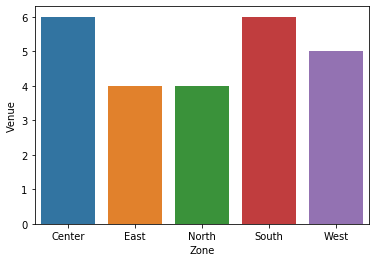

In [70]:
#Zonewise bar plot
import seaborn as sns
sns.barplot(x =Zone_Bakery_plot.index, y = Zone_Bakery_plot['Venue'], data = Bakery_grouped)

In [200]:
#Pune_Venues_Zone = Pune_venues.join(Zone_venues.set_index('Neighborhood'), on='')
#Pune_Venues_Zone = Pune_venues.join(Zone_venues, on='Venue')
#result = pd.concat([Zone_venues, Pune_venues], ignore_index=True, sort=False)
result1 = pd.merge(Pune_venues, Zone_venues, how='inner', on=['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
#Pune_Venues_Zone = pd.merge(Pune_venues, Zone_venues)
#Pune_Venues_Zone.head()
result1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Zone,Zone Latitude,Zone Longitude
0,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,Center,18.513021,73.878765
1,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,South,18.480641,73.862557
2,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,Center,18.513021,73.878765
3,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,South,18.480641,73.862557
4,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,West,18.498793,73.821123


<h3> 5) Let's check how many venues were returned for each neighborhood

In [201]:
result1.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Zone,Zone Latitude,Zone Longitude
Neighborhood,,,,,,,,,
AFMC,2,2,2,2,2,2,2,2,2
Bajirao Road,9,9,9,9,9,9,9,9,9
Bibvewadi,4,4,4,4,4,4,4,4,4
Boat Club Road,8,8,8,8,8,8,8,8,8
Deccan Gymkhana,19,19,19,19,19,19,19,19,19


<h3> 6) Finding out how many unique categories can be curated from all the returned venues

In [202]:
print('There are {} uniques categories.'.format(len(result1['Venue Category'].unique())))

There are 43 uniques categories.


<h3>7) Using one hot encoding for Venues

In [203]:
# one hot encoding
Pune_onehot = pd.get_dummies(result1[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Pune_onehot['Neighborhood'] = result1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Pune_onehot.columns[-1]] + list(Pune_onehot.columns[:-1])
Pune_onehot = Pune_onehot[fixed_columns]

Pune_onehot.head()

,Neighborhood,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food,Food Truck,General Entertainment,Gym,Gym / Fitness Center,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Lounge,Multiplex,Nightclub,Organic Grocery,Park,Parsi Restaurant,Plaza,Racetrack,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Stadium,Theme Park,Trail,Vegetarian / Vegan Restaurant
0,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [204]:
Pune_onehot.shape

(230, 44)

<h3>8) Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [205]:
Pune_grouped = Pune_onehot.groupby('Neighborhood').mean()
#dfObj.index[1]#Pune_grouped.head(50)

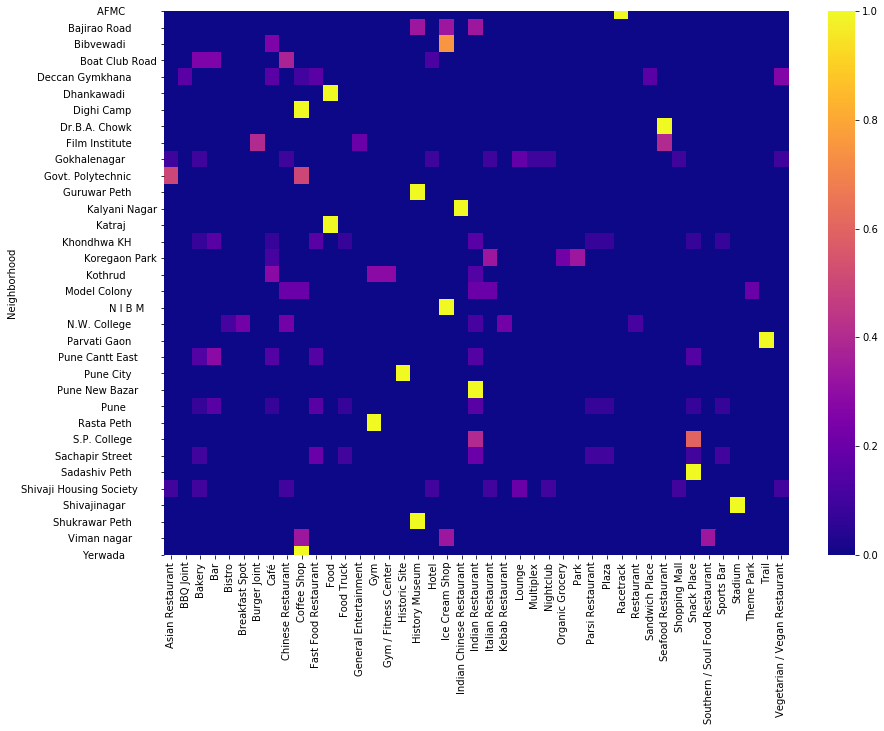

In [206]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(Pune_grouped, cmap ='plasma', ax=ax)

In [207]:
Pune_grouped_fine = Pune_grouped.drop(['General Entertainment', 'Gym', 'Gym / Fitness Center', 'Historic Site', 'History Museum', 'Hotel','Lounge','Nightclub','Organic Grocery','Park','Plaza','Racetrack','Stadium','Theme Park','Trail'], axis = 1)

In [165]:
#Pune_grouped_fine2 = Pune_grouped_fine.drop('Pune')

KeyError: "['Pune'] not found in axis"

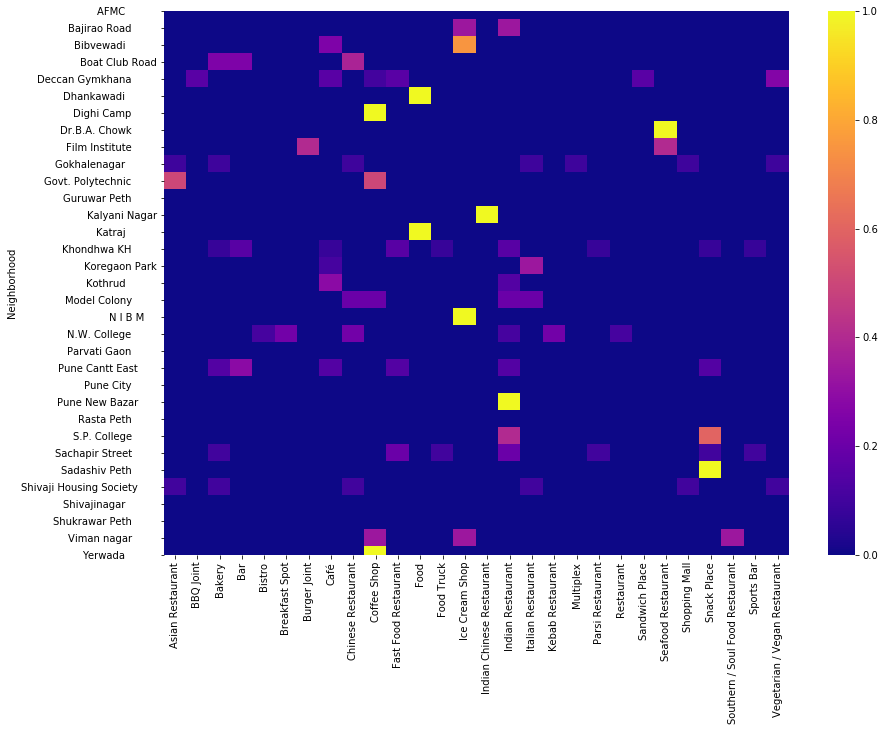

In [211]:
import matplotlib.pyplot as plt
modDfObj = Pune_grouped_fine.drop([Pune_grouped_fine.index[24]])
modDfObj.head(50)
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(modDfObj, cmap ='plasma', ax=ax)

In [199]:
# Delete row at index position 0 & 1
modDfObj = Pune_grouped_fine.drop([Pune_grouped_fine.index[0]])
modDfObj.head(50)

,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food,Food Truck,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Multiplex,Parsi Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bajirao Road,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Bibvewadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Boat Club Road,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.0,0.000000,0.375000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Deccan Gymkhana,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.0,0.157895,0.000000,0.105263,0.157895,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.0,0.000000,0.000000,0.000000,0.000000,0.263158
Dhankawadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Dighi Camp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Dr.B.A. Chowk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
Film Institute,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,0.000000,0.000000,0.000000,0.000000,0.000000
Gokhalenagar,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.090909


<h3>9) Let's print each neighborhood along with the top 5 most common venues

In [82]:
num_top_venues = 5

for hood in Pune_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Pune_grouped[Pune_grouped['Neighborhood'] == hood].T.reset_index()
    
    #print(temp)
    temp.columns = ['venue','freq']
    #print(temp)
    temp = temp.iloc[1:]
    
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AFMC          ----
           venue  freq
0   Cupcake Shop  0.33
1      Racetrack  0.33
2  Track Stadium  0.33
3            Zoo  0.00
4         Office  0.00


----Airport          ----
                  venue  freq
0                Bakery  0.14
1  Fast Food Restaurant  0.14
2             Bookstore  0.14
3            Smoke Shop  0.14
4                   Spa  0.14


----Akurdi          ----
                           venue  freq
0        Fruit & Vegetable Store   0.2
1                Thai Restaurant   0.2
2  Paper / Office Supplies Store   0.2
3           Fast Food Restaurant   0.2
4                     Playground   0.2


----Ammunition Factory Khadki      ----
                venue  freq
0                 ATM   1.0
1  Miscellaneous Shop   0.0
2         Pizza Place   0.0
3            Pharmacy   0.0
4    Parsi Restaurant   0.0


----Anandnagar          ----
                           venue  freq
0  Vegetarian / Vegan Restaurant   1.0
1                            Zoo   0.0
2           

             venue  freq
0              ATM   0.5
1   Mattress Store   0.5
2        Nightclub   0.0
3            Motel   0.0
4  Motorcycle Shop   0.0


----Lokmanyanagar          ----
               venue  freq
0  Indian Restaurant  0.33
1           Tea Room  0.33
2               Park  0.33
3          Nightclub  0.00
4              Motel  0.00


----M.Phulenagar          ----
               venue  freq
0     Shopping Plaza   1.0
1                Zoo   0.0
2  Mobile Phone Shop   0.0
3        Pizza Place   0.0
4           Pharmacy   0.0


----Mangalwar Peth        ----
                            venue  freq
0                     Coffee Shop   1.0
1                 Organic Grocery   0.0
2                 Motorcycle Shop   0.0
3              Mughlai Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


----Market Yard        ----
             venue  freq
0      Snack Place   0.5
1           Bakery   0.5
2              Zoo   0.0
3        Nightclub   0.0
4  Motorcycle Shop   0.0


----

<h3>10) Let's put that into a *pandas* dataframe

In [83]:
#Function sorted values
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [84]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Pune_grouped['Neighborhood']

for ind in np.arange(Pune_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Pune_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AFMC,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
1,Airport,Bookstore,Bakery,Smoke Shop,Spa,Airport Gate
2,Akurdi,Playground,Thai Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Fruit & Vegetable Store
3,Ammunition Factory Khadki,ATM,Yoga Studio,Exhibit,Food & Drink Shop,Food
4,Anandnagar,Vegetarian / Vegan Restaurant,Yoga Studio,English Restaurant,Food,Flea Market


<h3>11) Clustering Neighborhoods

In [85]:
# set number of clusters
kclusters = 5

Pune_grouped_clustering = Pune_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Pune_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([4, 4, 4, 2, 4, 4, 0, 4, 4, 4, 0, 2, 3, 4, 4, 3, 0, 4, 4, 4],
      dtype=int32)

<h3> 12) Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [86]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Pune_merged = Pune_filtered

# merge Pune_grouped with Pune_data to add latitude/longitude for each neighborhood
Pune_merged = Pune_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Pune_merged.head() # check the last columns!
New_Pune = Pune_merged.dropna(axis = 0, how ='any')
convert_dict = {'Cluster Labels': int, 
               } 
  
New_Pune = New_Pune.astype(convert_dict) 
New_Pune.head()

,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,AFMC,411040,18.506342,73.890503,4,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
3,Airport,411032,18.578542,73.908641,4,Bookstore,Bakery,Smoke Shop,Spa,Airport Gate
4,Akurdi,411035,18.646468,73.774262,4,Playground,Thai Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Fruit & Vegetable Store
24,Ammunition Factory Khadki,411003,18.567988,73.857668,2,ATM,Yoga Studio,Exhibit,Food & Drink Shop,Food
26,Anandnagar,411051,17.252763,74.175439,4,Vegetarian / Vegan Restaurant,Yoga Studio,English Restaurant,Food,Flea Market


<h3>13) Finally, let's visualize the resulting clusters

In [87]:
# create map
latitude = 18.516726
longitude = 73.856255
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(New_Pune['Latitude'], New_Pune['Longitude'], New_Pune['Neighborhood'], New_Pune['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    
for lat1, lon1, poi1, ven1 in zip(Bakery['Venue Latitude'], Bakery['Venue Longitude'], Bakery['Neighborhood'], Bakery['Venue']):
    label1 = folium.Popup(str(ven) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label1,
        color='b',
        fill=True,
        fill_color='r',
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

<h3>14) Examining Clusters

In [88]:
New_Pune.loc[New_Pune['Cluster Labels'] == 0, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
42,411027,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Café,Yoga Studio
49,411045,Indian Restaurant,Lounge,South Indian Restaurant,Juice Bar,Malay Restaurant
90,411038,Indian Restaurant,Chinese Restaurant,Dessert Shop,Diner,Fast Food Restaurant
156,411015,Café,Coffee Shop,Indian Restaurant,Exhibit,Food
168,411004,Café,Snack Place,Seafood Restaurant,Indian Restaurant,College Academic Building
193,411016,Indian Restaurant,Multiplex,Lounge,Coffee Shop,Ice Cream Shop
285,411052,Ice Cream Shop,Vegetarian / Vegan Restaurant,Indian Restaurant,Fast Food Restaurant,Dessert Shop
288,411034,Indian Restaurant,Bakery,Bar,Asian Restaurant,Yoga Studio
306,411024,Café,Yoga Studio,Food Court,Dessert Shop,Diner
330,411048,Indian Restaurant,Breakfast Spot,Ice Cream Shop,Fast Food Restaurant,Snack Place


In [89]:
New_Pune.loc[New_Pune['Cluster Labels'] == 1, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
289,411011,Coffee Shop,Yoga Studio,Food Court,Dessert Shop,Diner
420,411011,Coffee Shop,Yoga Studio,Food Court,Dessert Shop,Diner
783,411006,Coffee Shop,Yoga Studio,Food Court,Dessert Shop,Diner


In [90]:
New_Pune.loc[New_Pune['Cluster Labels'] == 2, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,411003,ATM,Yoga Studio,Exhibit,Food & Drink Shop,Food
50,411008,ATM,Park,Yoga Studio,Exhibit,Food
165,411003,ATM,Yoga Studio,Exhibit,Food & Drink Shop,Food
207,411003,ATM,Yoga Studio,Exhibit,Food & Drink Shop,Food
386,411047,ATM,Mattress Store,Yoga Studio,Falafel Restaurant,Food & Drink Shop


In [92]:
New_Pune.loc[New_Pune['Cluster Labels'] == 3, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
56,411021,Indian Restaurant,Yoga Studio,Exhibit,Food & Drink Shop,Food
84,411039,Auto Garage,Indian Restaurant,Exhibit,Food & Drink Shop,Food
191,411028,Indian Restaurant,Pizza Place,English Restaurant,Food,Flea Market
453,411002,Indian Restaurant,Yoga Studio,Exhibit,Food & Drink Shop,Food
543,411061,Indian Restaurant,Yoga Studio,Exhibit,Food & Drink Shop,Food


In [93]:
New_Pune.loc[New_Pune['Cluster Labels'] == 4, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,411040,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
3,411032,Bookstore,Bakery,Smoke Shop,Spa,Airport Gate
4,411035,Playground,Thai Restaurant,Fast Food Restaurant,Paper / Office Supplies Store,Fruit & Vegetable Store
26,411051,Vegetarian / Vegan Restaurant,Yoga Studio,English Restaurant,Food,Flea Market
35,411021,Farmers Market,Flea Market,Yoga Studio,Food Court,Department Store
43,411007,Park,Furniture / Home Store,Bar,Coffee Shop,Yoga Studio
41,411007,Ice Cream Shop,Dessert Shop,Café,Indian Restaurant,Lounge
47,411002,Ice Cream Shop,Breakfast Spot,Indian Restaurant,Jewelry Store,Juice Bar
72,411042,ATM,Diner,Snack Place,Furniture / Home Store,Yoga Studio
85,411026,Hotel,Yoga Studio,English Restaurant,Food,Flea Market


<h3> We can observe that bakeries are in better demand in cluster 4 compared to the other clusters.
    
<h3> Lets check how many neighborhoods belong to this cluster but do not have a bakery yet.

In [104]:
Cluster4_Data = New_Pune.loc[New_Pune['Cluster Labels'] == 4, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]
Pune_Venues_PC = pd.merge(Pune_venues, Pune_filtered, how='left', on=['Neighborhood'])
Pune_Venues_PC.shape
#Pune_Cluster4 = Pune_venues[Pune_venues['Postal Code'].isin(Cluster4_Data['Postal Code'])]

(833, 10)

In [100]:
Pune_Venues_PC.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category',
       'Postal Code', 'Latitude', 'Longitude'],
      dtype='object')

In [101]:
Pune_Venues_PC = Pune_Venues_PC[['Neighborhood', 'Postal Code', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Latitude', 'Longitude']]
Pune_Venues_PC.head()

,Neighborhood,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude
0,AFMC,411040,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,18.506342,73.890503
1,AFMC,411040,18.506342,73.890503,Race Course,18.506485,73.892134,Track Stadium,18.506342,73.890503
2,AFMC,411040,18.506342,73.890503,mongiri's,18.506278,73.893868,Cupcake Shop,18.506342,73.890503
3,Airport,411032,18.578542,73.908641,Pune Airport Arrival,18.578718,73.909355,Airport Service,18.578542,73.908641
4,Airport,411032,18.578542,73.908641,Relay Bookstore,18.579464,73.908680,Bookstore,18.578542,73.908641


In [114]:
PC_merged_cluster4 = Pune_Venues_PC[Pune_Venues_PC['Postal Code'].isin(Cluster4_Data['Postal Code'])]
print(PC_merged_cluster4.shape)
PC_merged_cluster4.head()



(721, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Latitude,Longitude
0,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,411040,18.506342,73.890503
1,AFMC,18.506342,73.890503,Race Course,18.506485,73.892134,Track Stadium,411040,18.506342,73.890503
2,AFMC,18.506342,73.890503,mongiri's,18.506278,73.893868,Cupcake Shop,411040,18.506342,73.890503
3,Airport,18.578542,73.908641,Pune Airport Arrival,18.578718,73.909355,Airport Service,411032,18.578542,73.908641
4,Airport,18.578542,73.908641,Relay Bookstore,18.579464,73.908680,Bookstore,411032,18.578542,73.908641


In [107]:
Cluster4_Bakery = PC_merged_cluster4[PC_merged_cluster4['Venue Category'] == 'Bakery']
Cluster4_Bakery.head()
print(Cluster4_Bakery.shape)

(25, 10)


In [115]:
Cluster4_NO_Bakery = PC_merged_cluster4[PC_merged_cluster4['Venue Category'] != 'Bakery']
Cluster4_NO_Bakery_gp = Cluster4_NO_Bakery.groupby('Postal Code').first()
print(Cluster4_NO_Bakery_gp.shape)
Cluster4_NO_Bakery_gp.head()

(38, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude
Postal Code,,,,,,,,,
411001,Boat Club Road,18.539517,73.878978,Suonmoi Chinese Restaurant,18.537519,73.879841,Chinese Restaurant,18.539517,73.878978
411002,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,18.513567,73.853342
411003,Ammunition Factory Khadki,18.567988,73.857668,State Bank of India ATM,18.569928,73.856792,ATM,18.567988,73.857668
411004,Deccan Gymkhana,18.515773,73.842652,Barbeque Nation,18.516237,73.842223,BBQ Joint,18.515773,73.842652
411005,Congress House Road,18.523303,73.853551,Sai Service Bajaj,18.522260,73.850185,Motorcycle Shop,18.523303,73.853551


In [116]:
# create map for bakeries
latitude = 18.516726
longitude = 73.856255
map_bak = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#markers_colors = []
for lat, lon, poi in zip(Cluster4_NO_Bakery_gp['Venue Latitude'], Cluster4_NO_Bakery_gp['Venue Longitude'], Cluster4_NO_Bakery_gp['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='b',
        fill=True,
        fill_color='r',
        fill_opacity=0.9).add_to(map_bak)
       
map_bak

<b>Result:</b>

Areas like Warje, Katraj and Khadakwasla fall in the main city but are a little on the outskirts of the city.
They may not be the best areas to be considered. 

Some of the pockets, even though they fall in the center of the city might not appeal to an audience looking 
for premium bakery products. Since our brand falls in the premium category we may not consider these as well.

We can see from the map that areas like Kalyani Nagar, Aundh, Model Colony and Keshav Nagar do not have sufficient bakeries but might be excellent locations for our bakery


<b>Conclusion:</b>

The above map shows areas which share similar characteristics as the areas which 
have good number of bakeries. 
Would like you to note that our data is only based on Bakery category in general and does not 
involve any sub-categories of bakeries depending on product types, ratings, price, menu, 
premium or non-premium etc.
Hence these recommendations may not be taken as final recomemndations and only be taken as data for 
further advanced analysis
